In [1]:
# pytorch
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet

# other stuff
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import myutils
from mymodels import VisionTransformer, ReconNet
from mymodels.vision_transformer import * # needed for loading current save models, but ugly
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# Device
device = 'cuda'

In [2]:
class fastMRIDataset(Dataset):
    def __init__(self, isval=False):
        self.isval = isval
        if not isval:
            self.data_path = '../singlecoil_train/'      
        else:
            self.data_path = '../singlecoil_val/'

        self.data = mri_data.SliceDataset(
            root=self.data_path,
            transform=self.data_transform,
            challenge='singlecoil',
            use_dataset_cache=True,
            )

        self.mask_func = subsample.EquispacedMaskFunc(
            center_fractions=[0.08],
            accelerations=[4], 
            )
            
    def data_transform(self, kspace, mask, target, data_attributes, filename, slice_num):
        if self.isval:
            seed = tuple(map(ord, filename))
        else:
            seed = None   
        kspace = transforms.to_tensor(kspace)
        masked_kspace, _ = transforms.apply_mask(kspace, self.mask_func, seed)        
        
        target = transforms.to_tensor(target)
        zero_fill = fastmri.ifft2c(masked_kspace)
        zero_fill = transforms.complex_center_crop(zero_fill, target.shape)   
        x = fastmri.complex_abs(zero_fill)
 

        x = x.unsqueeze(0)
        target = target.unsqueeze(0)

        return (x, target, data_attributes['max'])

    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]

        return data

In [3]:
# Create dataset
dataset = fastMRIDataset(isval=False)
val_dataset = fastMRIDataset(isval=True)

ntrain = 10
train_dataset, _ = torch.utils.data.random_split(dataset, [ntrain, len(dataset)-ntrain], generator=torch.Generator().manual_seed(42))
print(len(train_dataset))

10


In [4]:
batch_size = 1
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,generator=torch.Generator().manual_seed(42))
valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)  

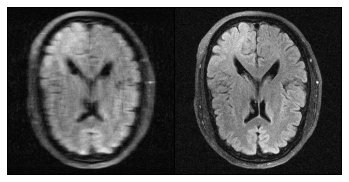

In [5]:
q = next(iter(valloader))
myutils.imshow(make_grid([q[0][0], q[1][0]], normalize = True, value_range=(0, q[2][0]/1.5)))    
plt.axis('off')
plt.show()

In [16]:
"""Init Model"""
# Vision Transformer
avrg_img_size = 340
patch_size = 10
depth = 8
num_heads = 9
embed_dim = 64
# gpsa_interval = [2, depth-1] # Convit
gpsa_interval = [-1, -1] # Vanilla Vit

net = VisionTransformer(
    avrg_img_size=avrg_img_size, 
    patch_size=patch_size, 
    in_chans=1, embed_dim=embed_dim, 
    depth=depth, num_heads=num_heads, mlp_ratio=4., 
    gpsa_interval=gpsa_interval,
    use_pos_embed=True, qkv_bias=False,
    )

# Unet
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=64,
#     num_pool_layers=4,
#     )

model = ReconNet(net).to(device)

print('#Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

#Params: 32679460
ReconNet(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 576, kernel_size=(10, 10), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA(
          (qkv): Linear(in_features=576, out_features=1728, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=576, out_features=576, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=576, out_features=2304, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=2304, out_features=576, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNo

In [22]:
# Validate model
def validate(model):
    valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)   
    model.eval()    
    ssim_ = myutils.SSIM().to(device)
    psnr_ = myutils.PSNR().to(device)
    psnrs = []
    ssims = []
    
    with tqdm(total=len(valloader)) as pbar:
        with torch.no_grad():
            for data in valloader:
                inputs, targets, maxval = data        
                outputs = model(inputs.to(device))
                ssims.append(ssim_(outputs, targets.to(device), maxval.to(device)))
                psnrs.append(psnr_(outputs, targets.to(device), maxval.to(device)))
                pbar.update(1)
    
    ssimval = torch.cat(ssims).mean()
    
    print(' Recon. PSNR: {:0.3f} pm {:0.2f}'.format(torch.cat(psnrs).mean(), 2*torch.cat(psnrs).std()))
    print(' Recon. SSIM: {:0.4f} pm {:0.3f}'.format(torch.cat(ssims).mean(), 2*torch.cat(ssims).std()))
                
    return (1-ssimval).item()

# Save model
def save_model(path, model, train_hist, val_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(), 
        }
    else:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        
    torch.save(train_hist, path + 'train_hist.pt')
    torch.save(val_hist, path + 'val_hist.pt')    
    torch.save(checkpoint,  path + 'checkpoint.pth')

In [8]:
"""Choose optimizer"""
criterion = SSIMLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
val_hist = []
best_val = float("inf")
path = './' # Path for saving model checkpoint and loss history
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005,
                                          total_steps=40, pct_start=0.1,
                                          anneal_strategy='linear',
                                          cycle_momentum=False,
                                          base_momentum=0., max_momentum=0., div_factor=0.1*40, final_div_factor=9)

In [ ]:
"""Train Model"""
for epoch in tqdm(range(0, 40)): # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    
    with tqdm(total=len(trainloader)) as pbar:
        for data in trainloader:
            inputs, targets, maxval = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device), maxval.to(device))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1.)
            optimizer.step()
            pbar.update(1)

            train_loss += loss.item()

    scheduler.step()
    train_hist.append(train_loss/len(trainloader))
    print('Epoch {}, Train loss.: {:0.4f}'.format(epoch+1, train_hist[-1]))
    
    if (epoch+1)%5==0:
        val_hist.append(validate(model))        
        if val_hist[-1] < best_val:
            save_model(path, model, train_hist, val_hist, optimizer, scheduler=scheduler)
            best_val = val_hist[-1]

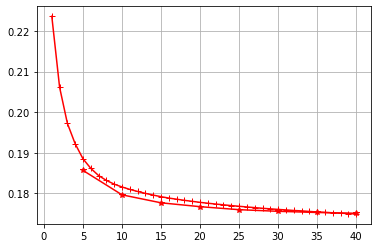

In [29]:
"""Loss History Plot"""
plt.plot(range(1,len(train_hist)+1), train_hist, 'r+-')
plt.plot(torch.linspace(5, len(train_hist), int(len(train_hist)/5)), val_hist[1:], 'r*-')
plt.grid('on')

1
 ssim: 0.5719728722007892
*ssim: 0.47187008345319625
 psnr: 27.316915657920042
*psnr: 25.089065748759186
 nmse: 0.03687779345313356
*nmse: 0.06159563952429721


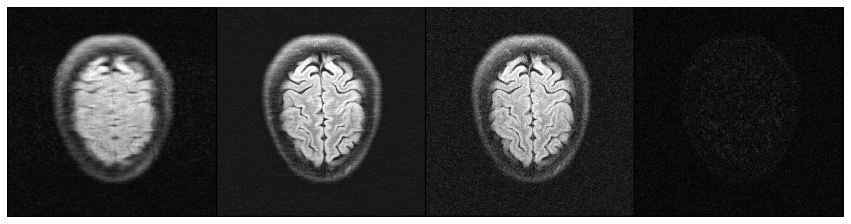

2
 ssim: 0.7003498489774326
*ssim: 0.633990424067747
 psnr: 29.97368678629174
*psnr: 29.146668879797165
 nmse: 0.042816521123522897
*nmse: 0.05179802803645475


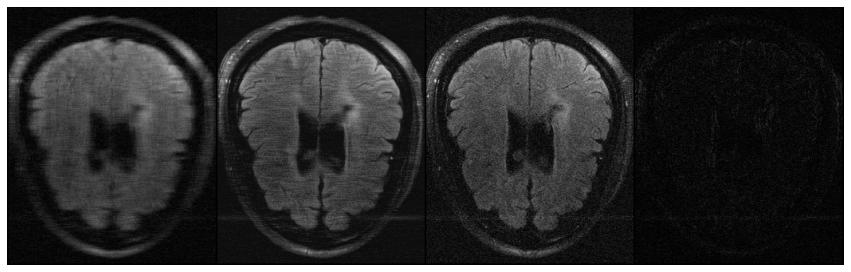

3
 ssim: 0.7881613632279768
*ssim: 0.694644368187001
 psnr: 33.32693628133482
*psnr: 31.223182788576413
 nmse: 0.026110389206794437
*nmse: 0.0423827069146341


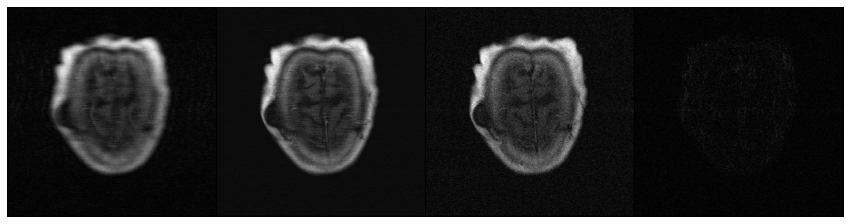

4
 ssim: 0.836015491223503
*ssim: 0.7245257563997012
 psnr: 34.06344233698587
*psnr: 31.24314243605843
 nmse: 0.01959323819724636
*nmse: 0.037509068476589774


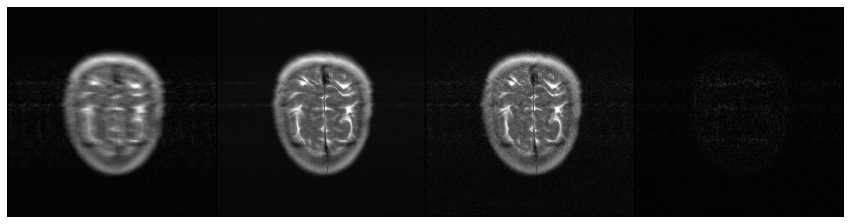

5
 ssim: 0.8656242753706797
*ssim: 0.7041896938470187
 psnr: 33.66472176519922
*psnr: 27.411277469969654
 nmse: 0.015486263194099414
*nmse: 0.06535685385964146


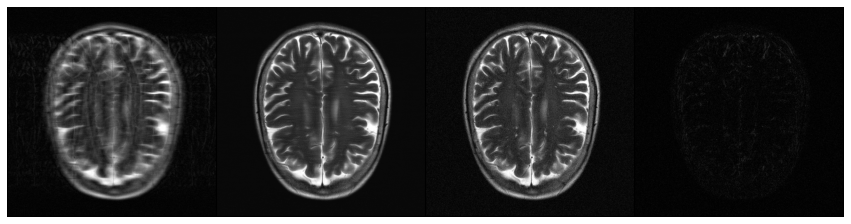

In [13]:
"""Qualitative Performance"""
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, generator=torch.Generator().manual_seed(40))
dataiter = iter(valloader)
model.eval()

with torch.no_grad():
    for k in range(0,5):    
        inputs, targets, maxval = dataiter.next()
        outputs = model(inputs.to(device)).cpu()
        inputs_ = inputs
        plt.figure(figsize=(15,7))
        myutils.imshow(make_grid([inputs_[0], outputs[0], targets[0], (targets[0]-outputs[0]).abs()],normalize = True, value_range=(0,maxval[0]/1.5)))    
        plt.axis('off')
        img_input = inputs_[0].numpy()
        img_noise = outputs[0].numpy()
        img = targets[0].numpy()
        print(k+1)
        print(' ssim:', ssim(img, img_noise, maxval[0].item()))
        print('*ssim:', ssim(img, img_input, maxval[0].item()))
        print(' psnr:', psnr(img, img_noise, maxval[0].item()))
        print('*psnr:', psnr(img, img_input, maxval[0].item()))
        print(' nmse:', nmse(img, img_noise, ))
        print('*nmse:', nmse(img, img_input))
        plt.show()